In [1]:
import sys
sys.path.insert(0, '/export/home/extragal/lucia.armillotta/pyathena')
import pyathena as pa

import os.path as osp
from pyathena.util import sb99
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from astropy import units as au

area_box_kpc2 = 1.024**2

basedir = '/export/home/extragal/francesco.chititegli/TIGRESS_1/'
sb0 = sb99.SB99(osp.join(basedir, 'Z014_M1E6_GenevaV00_logdt_10Gyr'))
sb1 = sb99.SB99(osp.join(basedir, 'Z014_M1E6_GenevaV00_dt01'))
rr0 = sb0.read_rad()
rr1 = sb1.read_rad()

# Combine two simulations
idx = np.where(rr0['time_Myr'] > rr1['time_Myr'][-1])[0]
time = np.concatenate((rr1['time_Myr'], rr0['time_Myr'][idx]))
logf = np.concatenate((rr1['logf'], rr0['logf'][idx]), axis=0)
time.shape, logf.shape

[SB99] Fixed mass ; logM: 6.0
[SB99] Fixed mass ; logM: 6.0


((1329,), (1329, 1221))

In [2]:
cells_width = 256
cells_heigth = 384

print('Total width:    ' + str(cells_width * 4) + ' pc;  in cells ' + str(cells_width))
print('Total heigth:   ' + str(cells_heigth * 4) + ' pc;  in cells  ' + str(cells_heigth))
print('Max heigth:     ' + str(cells_heigth * 2) + ' pc')
mass_tot = (1024 * 1024 * 42) * 768 / np.sqrt(768**2 + 245**2)
print('Total mass analitically computed: ' + str(mass_tot) + ' Msun')

data = np.loadtxt('/export/home/extragal/francesco.chititegli/TIGRESS_1/Halfa/Stars_exp.txt', usecols=(4, 6), comments='#')

young_mass = data[:, 0] # Msun
young_ages = data[:, 1] * 1e3 # Myr

print()
print('Max age [Myr]:  ' + str(np.nanmean(young_ages)))
print('Mean age [Myr]: ' + str(np.nanmax(young_ages)))

def Sigma_SFH_SP_cr(young_mass, young_ages, time):
    time_min, time_max = np.min(time), np.max(time)
    time_step = 1e1
    coarse_edges = np.arange(time_min, time_max + time_step, time_step)

    sfr_mass_per_bin, _ = np.histogram(young_ages, bins=coarse_edges, weights=young_mass)
    bin_widths = np.diff(coarse_edges)
    bin_centers = 0.5 * (coarse_edges[:-1] + coarse_edges[1:])

    Sigma_SFR_coarse = sfr_mass_per_bin / (bin_widths * 1e6 * area_box_kpc2)

    Sigma_SFR_interp = np.interp(time, bin_centers, Sigma_SFR_coarse, left=0, right=0)

    return Sigma_SFR_interp

Sigma_SFH_SP = Sigma_SFH_SP_cr(young_mass, young_ages, time)

Total width:    1024 pc;  in cells 256
Total heigth:   1536 pc;  in cells  384
Max heigth:     768 pc
Total mass analitically computed: 41956977.62690241 Msun

Max age [Myr]:  113.72783001639344
Mean age [Myr]: 234.36499999999998


In [3]:
from pyathena.microphysics.dust_draine import DustDraine
from scipy.interpolate import interp1d
from scipy.special import expn

def get_sfh(time):
    SFR_norm = np.zeros_like(time)
    # SFR_norm = np.where(time <  5.0 , 0.0,
    #            np.where(time < 10.0 , 1.0,
    #            np.where(time < 30.0 , 1.0/4.0,
    #            np.where(time < 100.0, 1.0/(4.0*1.2),
    #            np.where(time < 300.0, 1.0/4.0,
    #            np.where(time < 1000.0, 1.0/(4.0*1.1),
    #            np.where(time < 10000.0, 2.0, 1.0)))))))

    SFR_norm = np.where(time <  5.0 , 0.0,
           np.where(time < 10.0 , 0.0,
           np.where(time < 30.0 , 0.0,
           np.where(time < 100.0, 1.0/(4.0*1.2),
           np.where(time < 300.0, 1.0/4.0,
           np.where(time < 1000.0, 1.0/(4.0*1.1),
           np.where(time < 10000.0, 2.0, 1.0)))))))

    return SFR_norm

def Sigma_SFH_burst(time, time_burst = 9e3, dura_burst = 1e2):
    Sigma_SFR_norm = np.zeros_like(time)
    
    Sigma_FR_manual = mass_tot / (dura_burst * 1e6 * area_box_kpc2)
    t_start = time_burst - dura_burst / 2
    t_end = time_burst + dura_burst / 2
    
    Sigma_SFR_norm = np.where((time >= t_start) & (time < t_end), Sigma_FR_manual, Sigma_SFR_norm)

    print('Start burst: ' + str(t_start) + ' Myr')
    print('End burst:   ' + str(t_end) + ' Myr')
    print(r'$\Sigma$$_{SFR}$ [Msun yr^{-1} kpc}^{-2}] :' + str(np.max(Sigma_SFR_norm)))

    return Sigma_SFR_norm
    

Sigma_SFR0 = 4e-3
Sigma_SFR_const = np.repeat(2.5e-3, len(time))
Sigma_SFR_old = Sigma_SFH_burst(time)
Sigma_SFR_Z22 = Sigma_SFR_old + Sigma_SFH_SP
#Sigma_SFR_Z22 = get_sfh(time)

conv = (1.0*au.kpc**2).cgs.value
Llambda_per_area_Z22 = ((np.diff(time)*Sigma_SFR_Z22[:-1])*(10.0**logf[:-1]).T).sum(axis=1)/conv
Llambda_per_area_const = ((np.diff(time)*Sigma_SFR_const[:-1])*(10.0**logf[:-1]).T).sum(axis=1)/conv

Sigma_gas = 10.0*au.M_sun/au.pc**2
Z_dust = 1.0
dust_kind = 'Rv31'
d = DustDraine()
if dust_kind in ['Rv31', 'Rv31', 'Rv55', 'LMCavg', 'SMCbar']:
    dfdr = d.dfa[dust_kind]
else:
    print('dust_kind {0:s} not supported'.format(dust_kind))
    raise


f_Cabs = interp1d(np.log10(dfdr['lwav']),
                  np.log10(Z_dust*dfdr['K_abs']/d.GTD['Rv31']),
                  bounds_error=False)

# wavelength in micron
w_micron = rr0['wav'].values*1e-4
w_angstrom = rr0['wav'].values
kappa_dust_abs = Z_dust*(10.0**f_Cabs(np.log10(w_micron))*au.cm**2/au.g).cgs

def calzetti_k_lambda(wavelength_micron, Rv=4.05):
    wavelength = np.array(wavelength_micron)
    k_lambda = np.zeros_like(wavelength)

    mask1 = (wavelength >= 0.12) & (wavelength < 0.63)
    mask2 = (wavelength >= 0.63) & (wavelength <= 2.2)

    k_lambda[mask1] = 2.659*(-2.156 + 1.509/wavelength[mask1] - 0.198/wavelength[mask1]**2 + 0.011/wavelength[mask1]**3) + Rv
    k_lambda[mask2] = 2.659*(-1.857 + 1.040/wavelength[mask2]) + Rv

    return k_lambda
EBV = 0.2
k_lambda = calzetti_k_lambda(w_micron)
attenuation = 10**(-0.4 * EBV * k_lambda)

# Wavelength-dependent perpendicular dust optical depth
tau_perp = (Sigma_gas*kappa_dust_abs).to('').value

Jlambda_unatt_Z22 = Llambda_per_area_Z22/(4.0*np.pi)
Jlambda_Z22 = Jlambda_unatt_Z22/tau_perp*(1.0 - expn(2, 0.5*tau_perp))

Jlambda_unatt_const = Llambda_per_area_const/(4.0*np.pi)
Jlambda_const = Jlambda_unatt_const/tau_perp*(1.0 - expn(2, 0.5*tau_perp))

#Jlambda_Z22 = Jlambda_unatt_Z22/tau_perp*(1.0 - np.exp(tau_perp))
#Jlambda_const = Jlambda_unatt_const/tau_perp*(1.0 - np.exp(tau_perp))

Start burst: 8950.0 Myr
End burst:   9050.0 Myr
$\Sigma$$_{SFR}$ [Msun yr^{-1} kpc}^{-2}] :0.4001329195680848


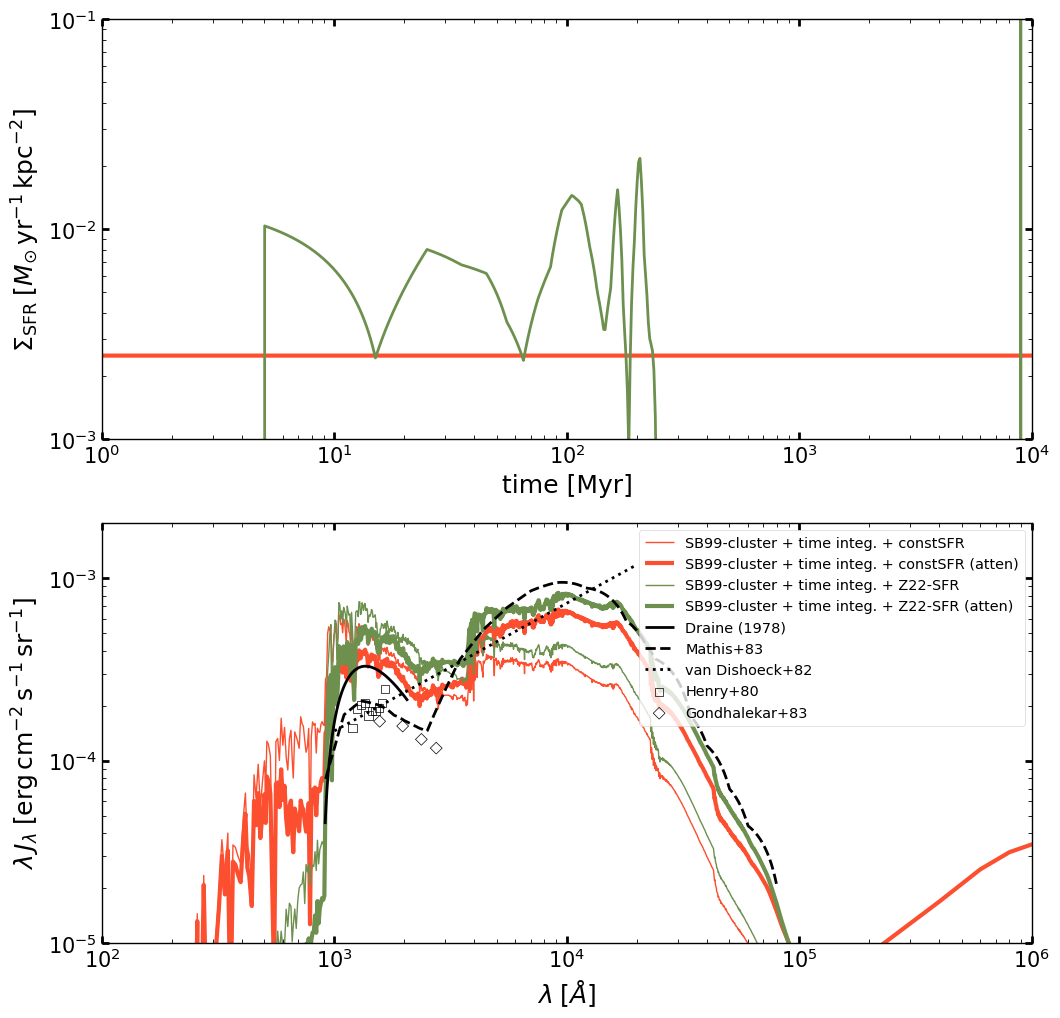

In [80]:
from pyathena.plt_tools.set_plt import set_plt_fancy
from pyathena.util import rad_isrf, rad_uvb
from astropy import constants as ac

set_plt_fancy()
plt_Z22 = True
plt_const_SFR = False # const SFR from SB99 simulation
plt_const = True # const SFR reconstructed from cluster SB99 simulation
plt_ISRF = True
plt_obs = True

fig,axes = plt.subplots(2,1,figsize=(12,12))
plt.sca(axes[0])
if plt_const:
    plt.loglog(time, Sigma_SFR_const, c='C1', ls='-',lw=3)

if plt_Z22:
    plt.loglog(time, Sigma_SFR_Z22, c='C3', ls='-')

plt.xlim(1e0,1e4)
plt.ylim(1e-3,1e-1)
plt.xlabel('time [Myr]')
plt.ylabel(r'$\Sigma_{\rm SFR}\;[M_{\odot}\,{\rm yr}^{-1}\,{\rm kpc}^{-2}]$')

plt.sca(axes[1])

if plt_const:
    plt.loglog(rr0['wav'], Jlambda_unatt_const*rr0['wav'], c='C1', ls='-', lw=1,
               label=r'SB99-cluster + time integ. + constSFR')
    plt.loglog(rr0['wav'], Jlambda_const*rr0['wav'], c='C1', ls='-', lw=3,
               label=r'SB99-cluster + time integ. + constSFR (atten)')
if plt_Z22:
    plt.loglog(rr0['wav'], Jlambda_unatt_Z22*rr0['wav'], c='C3', ls='-', lw=1,
               label=r'SB99-cluster + time integ. + Z22-SFR')
    plt.loglog(rr0['wav'], Jlambda_Z22*rr0['wav'], c='C3', ls='-', lw=3,
               label=r'SB99-cluster + time integ. + Z22-SFR (atten)')

if plt_const_SFR:
    r0 = sb99.get_ISRF_SB99_plane_parallel(Sigma_gas=Sigma_gas,
                                           Sigma_SFR=Sigma_SFR0*au.M_sun/au.kpc**2/au.yr,
                                           age_Myr=10e3,
                                           Z_dust=1.0, dust_kind='Rv31', rotation='V00',
                                           Z_star=0.014, verbose=True)
    plt.loglog(r0['w_angstrom'], r0['w_angstrom']*r0['Jlambda_unatt'], c='C0', ls='--', lw=1,
               label='SB99-cont-SF')
    plt.loglog(r0['w_angstrom'], r0['w_angstrom']*r0['Jlambda'], c='C0', ls='--', lw=3,
               label='SB99-cont-SF (atten.)')

wav2 = np.logspace(np.log10(912), np.log10(2068), 1000)*au.angstrom
wav3 = np.logspace(np.log10(912), np.log10(10e4), 1000)*au.angstrom
wav4 = np.logspace(np.log10(2068), np.log10(10e4), 1000)*au.angstrom
wav5 = np.logspace(np.log10(1000), np.log10(2e4), 1000)*au.angstrom
nu2 = (ac.c/wav2).to('Hz')
nu3 = (ac.c/wav3).to('Hz')
nu4 = (ac.c/wav4).to('Hz')
nu5 = (ac.c/wav5).to('Hz')
E2 = (nu2*ac.h).to('eV')

if plt_ISRF:
    # Note that J_lambda = nuJnu/lambda
    plt.semilogy(wav2, rad_isrf.nuJnu_Dr78(E2), c='k', label='Draine (1978)')
    plt.semilogy(wav3, rad_isrf.Jlambda_MMP83(wav3)*wav3, c='k', ls='--',
                 label='Mathis+83')
    plt.semilogy(wav5, rad_isrf.Jnu_vD82(wav5)*(ac.h*ac.c/wav5).to('erg')*nu5/(4*np.pi), ls=':', c='k',
                 label='van Dishoeck+82')


plt.xlim(1e2,1e6)
plt.ylim(1e-5,2e-3)
plt.xlabel(r'$\lambda\;[\AA]$')
plt.ylabel(r'$\lambda\,J_{\lambda}\;[{\rm erg}\,{\rm cm}^{-2}\,{\rm s}^{-1}\,{\rm sr}^{-1}]$')

plt.xscale('log')
plt.yscale('log')

if plt_obs:
    w_F80 = np.array([1195,1250,1300,1350,1400,1450,1500,1550,1600,1650])*au.angstrom
    u_F80 = np.array([5.29, 6.46, 6.53, 6.41, 5.29, 5.40, 5.22, 5.26, 5.41, 6.26])*\
            1e-17*au.erg/au.cm**3/au.angstrom
    J_F80 = (u_F80/(4*np.pi*au.sr)*ac.c).to('erg s-1 cm-2 sr-1 angstrom-1')

    plt.scatter(w_F80, w_F80*J_F80, marker='s', facecolors='none', edgecolors='k', label='Henry+80')

    w_G83 = np.array([1565,1965,2365,2740])*au.angstrom
    F_G83 = np.array([13.19,9.89,6.95,5.37])*1e-7*au.erg/au.cm**2/au.s/au.angstrom
    J_G83 = F_G83/(4.0*np.pi*au.sr)
    plt.scatter(w_G83, w_G83*J_G83, marker='D', facecolors='none', edgecolors='k', label='Gondhalekar+83')
    
plt.legend(fontsize='x-small', loc=1)

# fname = '/tigress/jk11/figures/NEWCOOL/fig-ISRF-SB99-SFH'
# if plt_const:
#     fname += '-SFconst'
# if plt_Z22:
#     fname += '-Z22'
# if plt_obs:
#     fname += '-obs'

# fplt.savefig(fname + '.png', dpi=200, bbox_inches='tight')